In [7]:
from __future__ import division, print_function
import numpy as np
from numpy import inf, ndarray
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import keras
import re
from keras import optimizers
from keras import losses
from keras import regularizers
import keras.backend as K
from keras.models import model_from_json
from keras.models import load_model, Model
from tempfile import TemporaryFile
from keras import layers
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
# matplotlib inline
from keras.callbacks import History, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation
from keras.layers import CuDNNLSTM, Dense, Bidirectional, Dropout, Layer
from keras.initializers import glorot_normal
from keras.regularizers import l2
from functools import partial
from multiprocessing import cpu_count, Pool
from keras.utils.generic_utils import Progbar
from copy import deepcopy
from NGF.utils import filter_func_args, mol_shapes_to_dims
import NGF.utils
import NGF_layers.features
import NGF_layers.graph_layers
from NGF_layers.features import one_of_k_encoding, one_of_k_encoding_unk, atom_features, bond_features, num_atom_features, num_bond_features
from NGF_layers.features import padaxis, tensorise_smiles, concat_mol_tensors
from NGF_layers.graph_layers import temporal_padding, neighbour_lookup, NeuralGraphHidden, NeuralGraphOutput
from math import ceil

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


# Load all smiles of train data

In [22]:
#Load unique smiles and tensorize them
smiles = pd.read_csv('../../deepSIBA/learning/data/mcf7/mcf7q1smiles.csv',index_col=0)

X_atoms, X_bonds, X_edges = tensorise_smiles(smiles.x, max_degree=5, max_atoms = 60)

In [23]:
smiles=list(smiles['x'])

In [24]:
#num_molecules = len(df)
max_atoms = 60
max_degree = 5
num_atom_features = 62
num_bond_features = 6


# Define custom loss and layers

In [12]:
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.log(sigma) + 0.5*tf.div(tf.square(y_true - y_pred), sigma)) + 1e-6
    return gaussian_loss

class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(128, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(128, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]
    


# Model

In [13]:
p = {'lr': 0.0001,
     'nfilters': int(32),
     'size': int(8),
     'conv_width' : 128,
     'fp_length' : 256,
     'size_drug_1' : 8,
     'size_drug_2' : 4,
     'size_protein_1' : 8,
     'size_protein_2' : 16,
     'size_protein_3' : 3,
     'batch_size': int(128),
     'dense_size': int(256),
     'dense_size_2': 512,
     'dropout': 0.25,
     'l2reg': 0.01}

In [14]:
def enc_nikos(params, lr_value, conv_width, fp_length):
        
    ### encode smiles
    
    atoms0 = Input(name='atom_inputs', shape=(max_atoms, num_atom_features),dtype = 'float32')
    bonds = Input(name='bond_inputs', shape=(max_atoms, max_degree, num_bond_features),dtype = 'float32')
    edges = Input(name='edge_inputs', shape=(max_atoms, max_degree), dtype='int32')

    g1 = NeuralGraphHidden(conv_width , activ = None, bias = True , init = 'glorot_normal')([atoms0,bonds,edges])
    g1 = BatchNormalization(momentum=0.6)(g1)
    g1 = Activation('relu')(g1)
    #g1 = keras.layers.Dropout(0.25)(g1) #this enables dropout also in test-time
    g2 = NeuralGraphHidden(conv_width , activ = None, bias = True , init = 'glorot_normal')([g1,bonds,edges])
    g2 = BatchNormalization(momentum=0.6)(g2)
    g2 = Activation('relu')(g2)
    #g2 =keras.layers.Dropout(0.25)(g2)
    g3 = NeuralGraphHidden(conv_width , activ = None, bias = True , init = 'glorot_normal')([g2,bonds,edges])
    g3 = BatchNormalization(momentum=0.6)(g3)
    g3 = Activation('relu')(g3)
    #g3 =keras.layers.Dropout(0.25)(g3)
    
    g4=keras.layers.Conv1D(128, 29, activation=None, use_bias=False, kernel_initializer='glorot_uniform')(g3)
    g4= BatchNormalization(momentum=0.6)(g4)
    g4 = Activation('relu')(g4)
    g4=keras.layers.Dropout(0.25)(g4)
    

    #End of encoding
    interactionModel = keras.Model(inputs=[atoms0, bonds, edges], outputs= g4)

    print(interactionModel.summary())
    return interactionModel

In [15]:
# Initialize encoder
encoder_nikos = enc_nikos(p, 0.001, 128, 256)
    
# Initialize model
atoms0_1 = Input(name='atom_inputs_1', shape=(max_atoms, num_atom_features),dtype = 'float32')
bonds_1 = Input(name='bond_inputs_1', shape=(max_atoms, max_degree, num_bond_features),dtype = 'float32')
edges_1 = Input(name='edge_inputs_1', shape=(max_atoms, max_degree), dtype='int32')

atoms0_2 = Input(name='atom_inputs_2', shape=(max_atoms, num_atom_features),dtype = 'float32')
bonds_2 = Input(name='bond_inputs_2', shape=(max_atoms, max_degree, num_bond_features),dtype = 'float32')
edges_2 = Input(name='edge_inputs_2', shape=(max_atoms, max_degree), dtype='int32')

encoded_1 = encoder_nikos([atoms0_1,bonds_1,edges_1])
encoded_2 = encoder_nikos([atoms0_2,bonds_2,edges_2])

L1_layer = keras.layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_1, encoded_2])

fc1=keras.layers.Conv1D(128, 17, activation=None, use_bias=False, kernel_initializer='glorot_uniform')(L1_distance)
fc1= BatchNormalization(momentum=0.6)(fc1)
fc1= Activation('relu')(fc1)
fc1=keras.layers.Dropout(0.25)(fc1)

fc2=keras.layers.Conv1D(128, 1, activation=None, use_bias=False, kernel_initializer='glorot_uniform')(fc1)
fc2= BatchNormalization(momentum=0.6)(fc2)
fc2= Activation('relu')(fc2)
fc2=keras.layers.Dropout(0.25)(fc2)


fc3=keras.layers.MaxPooling1D(pool_size= 4, strides=None, padding='valid', data_format='channels_last')(fc2)
fc3 = BatchNormalization(momentum=0.6)(fc3)
fc3=keras.layers.Flatten()(fc3)

fc4 = keras.layers.Dense(256,activation = None,kernel_regularizer=regularizers.l2(p['l2reg']), kernel_initializer='glorot_normal')(fc3)
fc4 = BatchNormalization(momentum=0.6)(fc4)
fc4 = Activation('relu')(fc4)
fc4 = keras.layers.Dropout(0.25)(fc4)


fc5 = keras.layers.Dense(128,activation = None,kernel_regularizer=regularizers.l2(p['l2reg']), kernel_initializer='glorot_normal')(fc4)
fc5 = BatchNormalization(momentum=0.6)(fc5)
fc5 = Activation('relu')(fc5)
fc5 = keras.layers.Dropout(0.25)(fc5)

fc6 = keras.layers.Dense(128,activation = None,kernel_regularizer=regularizers.l2(p['l2reg']), kernel_initializer='glorot_normal')(fc5)
fc6 = BatchNormalization(momentum=0.6)(fc6)
fc6 = Activation('relu')(fc6)
fc6 = keras.layers.Dropout(0.25)(fc6)


mu, sigma = GaussianLayer(1, name='main_output')(fc6)


siamese_net = Model(inputs=[atoms0_1,bonds_1,edges_1,atoms0_2,bonds_2,edges_2],outputs=mu)
print(siamese_net.summary())
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
siamese_net.compile(optimizer= adam,loss= custom_loss(sigma))

W1019 16:29:43.066511 139735556601664 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1019 16:29:43.069628 139735556601664 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1019 16:29:43.070543 139735556601664 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1019 16:29:43.190006 139735556601664 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_defau

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom_inputs (InputLayer)        (None, 60, 62)       0                                            
__________________________________________________________________________________________________
bond_inputs (InputLayer)        (None, 60, 5, 6)     0                                            
__________________________________________________________________________________________________
edge_inputs (InputLayer)        (None, 60, 5)        0                                            
__________________________________________________________________________________________________
neural_graph_hidden_1 (NeuralGr (None, 60, 128)      44160       atom_inputs[0][0]                
                                                                 bond_inputs[0][0]                
          

W1019 16:29:44.397294 139735556601664 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1019 16:29:44.758790 139735556601664 deprecation_wrapper.py:119] From /home/biolab/miniconda3/envs/tf1/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1019 16:29:44.761974 139735556601664 deprecation.py:323] From <ipython-input-12-c43ce433651a>:3: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom_inputs_1 (InputLayer)      (None, 60, 62)       0                                            
__________________________________________________________________________________________________
bond_inputs_1 (InputLayer)      (None, 60, 5, 6)     0                                            
__________________________________________________________________________________________________
edge_inputs_1 (InputLayer)      (None, 60, 5)        0                                            
__________________________________________________________________________________________________
atom_inputs_2 (InputLayer)      (None, 60, 62)       0                                            
__________________________________________________________________________________________________
bond_input

# Load libraries for visualization later

In [16]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
from rdkit.Chem import ChemicalFeatures
from rdkit import rdBase
from rdkit.RDPaths import RDDocsDir
from rdkit.RDPaths import RDDataDir
import os
from rdkit.Chem import AllChem
print(rdBase.rdkitVersion)
IPythonConsole.ipython_useSVG=True

2018.09.1


In [17]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

# Example for important atoms visualization

In [18]:
def atoms_colors(m1,atoms_grad,colors_at,num_atoms):
    atom_ind=[]
    for i in range(num_atoms):
        if atoms_grad[i]>np.mean(atoms_grad):
        #if atoms_grad[i]>0:
            #c=tuple(((atoms_grad[i]-np.min(atoms_grad))/(np.max(atoms_grad)-np.min(atoms_grad)))[0]*a+b for a,b in zip((0,-1,0),(1,1,0)))
            #c=tuple(((atoms_grad[i]-np.min(atoms_grad))/(np.max(atoms_grad)-np.min(atoms_grad)))*a+b for a,b in zip((0,-1,0),(1,1,0)))
            c=tuple(((atoms_grad[i]-np.mean(atoms_grad))/(np.max(atoms_grad)-np.mean(atoms_grad)))*a+b for a,b in zip((0,-1,0),(1,1,0)))
            colors_at.update( {i : c} )
            atom_ind.append(i)
    return(colors_at,atom_ind)

In [19]:
#Fludarabine
smi_query=["Nc1nc(F)nc2c1ncn2C1OC(CO)C(O)C1O"]
smis_list=["Cn1cc(C2=C(c3cn(CCCSC(=N)N)c4ccccc34)C(=O)NC2=O)c2ccccc21",
           "O=[N+]([O-])c1ccc2[nH]c(CNc3nc(N4CCOCC4)nc4c3ncn4-c3ccsc3)nc2c1",
           "Cn1c(=O)cc(OCCCC(=O)Nc2cc(C(F)(F)F)ccn2)c2ccccc21",
           "FC(F)(F)c1ccc2[nH]c(CNc3nc(N4CCOCC4)nc4c3ncn4-c3ccsc3)nc2c1",
           "CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O)ccc3nc2-1",
           "OCCCNc1cc(-c2ccnc(Nc3cccc(Cl)c3)n2)ccn1",
           "N#Cc1cc(-c2ccnc(Nc3ccc(-n4cnc(-c5cccnc5)n4)cc3)n2)cc(N2CCOCC2)c1",
           "CN(c1ncccc1CNc1nc(Nc2ccc3c(c2)CC(=O)N3)ncc1C(F)(F)F)S(C)(=O)=O",
           "Cc1ccc(F)c(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)cc2)c1"]

In [20]:
def imp_atom_query_ensembled(smi_query,smis_list,smiles,X_atoms, X_bonds, X_edges,NUM):
    
    #Smiles are the already tensorised smiles of the training which are neighbors of the query smile
    from math import log,exp

    m2=Chem.MolFromSmiles(smi_query[0])
    n2=m2.GetNumAtoms()
    atom_2,bond_2,edge_2=tensorise_smiles(smi_query[0:1], max_degree=5, max_atoms = 60)
    
    all_imps2=[]
    all_imps1=[]
    kk=1
    
    for mod in range(50):
        print('Find counts for Model:%s'%mod)
        siamese_net.compile(optimizer= adam,loss= custom_loss(sigma))
        #sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        K.set_session(sess)
        siamese_net.load_weights(f'../../deepSIBA/learning/trained_models/a375/alldata/models/siam_no_augment_{mod}.h5')
        outputTensor = siamese_net.output
        inputTensor = siamese_net.input
        grad = K.gradients(outputTensor, inputTensor)
        grad = [grad[0],grad[1],grad[3],grad[4]]

        for q in range(len(smis_list)):
            print('Start calculating important atoms for similar %s out of %s'%(q+1,len(smis_list)))
            m1=Chem.MolFromSmiles(smis_list[q])
            n1=m1.GetNumAtoms()
            counter=smiles.index(smis_list[q])


            atom_1=X_atoms[counter:counter+1]
            bond_1=X_bonds[counter:counter+1]
            edge_1=X_edges[counter:counter+1]
        
            eval_grad = sess.run(grad,
                                 {'atom_inputs_1:0':atom_1,'bond_inputs_1:0':bond_1,'edge_inputs_1:0':edge_1,'atom_inputs_2:0':atom_2,
                                  'bond_inputs_2:0':bond_2,'edge_inputs_2:0':edge_2})    
            
            DaY=(eval_grad[2][0]*atom_2[0]).sum(axis=1)
            atoms_grad2=np.copy(DaY)
            import operator
            cc={}
            for x in range(n2):
                c=atoms_grad2[x]
                cc.update({x:c})
        
            sorted_at2=sorted(cc.items(), key=operator.itemgetter(1))
            if (np.where(DaY>0)[0].shape[0]>=(len(sorted_at2)-round(len(sorted_at2)-NUM*n2))):
                sorted_at2=sorted_at2[round(len(sorted_at2)-NUM*n2):len(sorted_at2)]
            else:
                beg=np.where(DaY>0)[0].shape[0]
                sorted_at2=sorted_at2[beg:len(sorted_at2)]

            atom_ind2=[]
            for x in sorted_at2:
                atom_ind2.append(x[0])

            #Find intersect of important atoms    
            if kk==1:
                all_imps2=atom_ind2.copy()
            else:
                all_imps2=all_imps2+atom_ind2 
            kk+=1
 
        print('Ended counts for model:%s'%mod)
        
    
    print('Ended ensembled important atoms calculation')
    counts=[]
    for x in range(n2):
        counts.append(all_imps2.count(x))
    counts=np.array(counts)
        
        
        
    colors_at2={}
    colors_at2,atom_ind2=atoms_colors(m2,counts,colors_at2,n2)
    
    output_dict={"counts":counts,"atoms":atom_ind2,"colors":colors_at2}
    print('END')
    return output_dict

In [ ]:
#Smiles are the already tensorised smiles of the training which are neighbors of the query smile
NUM=0.3 # percentage of top importants
out=imp_atom_query_ensembled(smi_query,smis_list,smiles,X_atoms, X_bonds, X_edges,NUM)

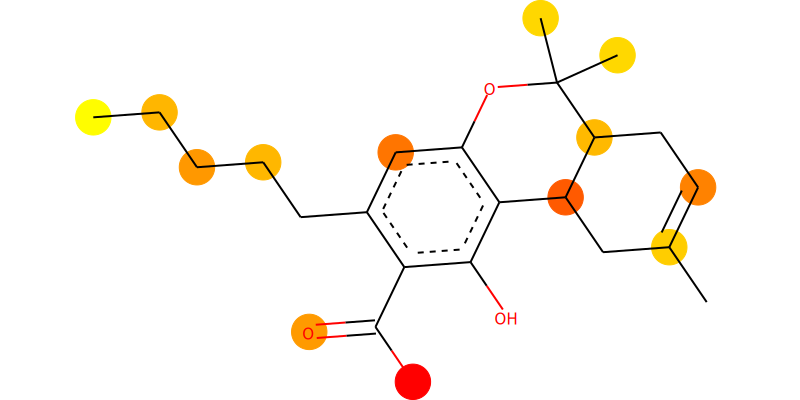

In [20]:
from cairosvg import svg2png
m1=Chem.MolFromSmiles(smi_query[0])
rdDepictor.Compute2DCoords(m1)
drawer = rdMolDraw2D.MolDraw2DSVG(800,400)
drawer.DrawMolecule(m1,highlightAtoms=list(map(int,out["atoms"])),highlightAtomColors=out["colors"],highlightBonds=[])
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

In [21]:
out_im='../results/res_imp.png'
svg2png(bytestring=svg,write_to=out_im)